<h1>Exploring the data in high dimensional space</h1>

The PDMC samples have been gated by a supervised algorithm, providing one methodology for feature extraction. Clustering is another method that can be used to this end. This is an 'unbiased' approach as events are clustered together based on simularities in high dimensional space as opposed to gating, which is biased by the choice of sequential two-dimensional plots in which to choose cell populations.

The immunova clustering module (located in `immunova.flow.clustering`) offers numerous classes for different clustering methodologies. It also provides the Explorer class, which given a dataframe generated from one of these objects, provides tools for visualisation and comparison to clinical meta-data.

The classes and their intended use are described below, we will use them in this order to explore our PDMC T cell panel experiment.

* GlobalClustering - creates a concatenated dataframe of all (or many) samples from an FCS Experiment by uniformally sampling a fixed number of cells from each. Clustering is then performed on this concatenated dataframe.
* SingleClustering - used to perform clustering on a single sample.
* MetaClustering - given that single clustering has been performed on each sample (or many samples) of an FCS Experiment, perform meta-clustering as described in the original PhenoGraph paper (calculate the centroid of each cluster [median of each feature] and run PhenoGraph clustering on these centroids.

In [1]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.mongo_setup import pd_init
from immunova.data.fcs_experiments import FCSExperiment
from immunova.flow.clustering.main import GlobalClustering, SingleClustering, MetaClustering, Explorer, ClusteringDefinition
from warnings import filterwarnings
from tqdm import tqdm_notebook
import matplotlib
import pandas as pd
import os
filterwarnings('ignore')
pd_init()

/home/ross/immunova/env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/ross/immunova/env/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<h2>Global clustering of T panel in PDMC samples</h2>

Let's load in the PDMC T panel experiment. Remember this objext gives reference to all the FCS files associated with the T panel staining of PDMC samples.

In [2]:
texp = FCSExperiment.objects(experiment_id='PD_T_PDMCs').get()

In [3]:
exclude = [f'{x}_pdmc_t' for x in ['209-03', '210-14', '273-01', 
                                   '298-01', '322-01', '237-06', 
                                   '302-01', '307-01']]
exclude.append('PD_T_PDMCs_sampled_data')
samples = [s for s in texp.list_samples() if s not in exclude]

In [4]:
len(samples)

37

After exclusions of problematic samples we have 37 samples for analysis.

Before clustering you have to create a 'clustering definition'. This describes the methodology to be used and can be reused across multiple clustering operations. We will create a definition for the PhenoGraph clustering. We include information like a unique idenfitier, the method to use (in this case, PhenoGraph) and the algorithms expected hyper parameters. Give the hyperparameters as a list of tuples, where the first value is the hyperparamters name and the second the value. Also provide the transformation method (default = 'logicle'), root population, and cluster prefix. Root population is the gated population that clustering is performed on (e.g. we only want to perform clustering on single live CD3+ cells in this case). Cluster prefix is a simple prefix included in the cluster names and is optional. 

In [5]:
features = ['CCR7', 'CD161', 'CD27',
            'CD4', 'CD45RA', 'CD8', 
            'CXCR3', 'FSC-A', 'FSC-H',
            'PanGD', 'SSC-A', 'SSC-W',
            'Va7.2', 'Vd2']

In [6]:
cdef = ClusteringDefinition(clustering_uid='PhenoGraph',
                            method='PhenoGraph',
                            parameters=[('k', 30)],
                            features=features,
                            transform_method='logicle',
                            root_population='single_Live_CD3+',
                            cluster_prefix='global')
cdef.save()

<ClusteringDefinition: ClusteringDefinition object>

In [7]:
gclust = GlobalClustering(clustering_definition=cdef)

In [8]:
gclust.load_data(experiment=texp, samples=samples, sample_n=10000)

------------ Loading flow data: PD_T_PDMCs ------------



------------ Completed! ------------


In [9]:
gclust.data.shape

(331755, 22)

In [10]:
gclust.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id'],
      dtype='object')

We now have a concatenated dataset that has 331,755 cells (~10000 from each patient) and 22 columns listed above. Original index is the index associated to the original dataframe in the samples database entry, which means we can refer back to this if necessary after manipulation of the data. Population label is the name of the population a cell has been 'gated' into. Pt_id is the patients unique identifier.

I shall now run clustering on this dataset as per the definition we created above. To do this all I have to do is call the `cluster` method.

In [11]:
gclust.cluster()

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 123.36699295043945 seconds
Jaccard graph constructed in 21.691575288772583 seconds
Wrote graph to binary file in 18.314216375350952 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.879901
After 8 runs, maximum modularity is Q = 0.881375
Louvain completed 28 runs in 708.1751549243927 seconds
PhenoGraph complete in 872.2426679134369 seconds


Now we have clustered we ant to visualise. Each of the clustering objects can generate an Explorer object. This 'carries' a standardised pandas dataframe and has multiple methods for associating data with clinical meta-data. Immunova is built around a document database where each flow file is associated directly with the clinical meta data. This means we can simple choose a common field name like 'status' or 'gender' and assoicate it to our single cell data. We can also access timeseries data and data with 'depth' such as the pathogens isolated from a patient and things like gram-status and HMBPP stauts.

We use the following methods of our Explorer object to associate single cell data to clinical meta-data:
* `load_meta` - given a field name associate to single cell data
* `load_biology_data` - summarise a blood test or some other time series data
* `load_infectious_data` - summarise the infectious agents isolate from each patient; creates four new columns, one with a list of organisms isolated, one with the common isolate type e.g. bacteria/virus/fungal, the common gram status amongst isolates, and the common HMBPP/Ribo status

In [12]:
gexplorer = gclust.explorer()

In [13]:
help(gexplorer.load_meta)

Help on method load_meta in module immunova.flow.clustering.main:

load_meta(variable:str) method of immunova.flow.clustering.main.Explorer instance
    Load meta data for each patient. Must be provided with a variable that is a field with a single value
    NOT an embedded document. A column will be generated in the Pandas DataFrame stored in the attribute 'data'
    that pertains to the variable given and the value will correspond to that of the patients.
    :param variable: field name to populate data with



In [14]:
help(gexplorer.load_biology_data)

Help on method load_biology_data in module immunova.flow.clustering.main:

load_biology_data(test_name:str, summary_method:str='average') method of immunova.flow.clustering.main.Explorer instance
    Load the pathology results of a given test from each patient and populate 'data' accordingly. As multiple
    results may exist for one particular test, a summary method should be provided, this should have a value as
    follows:
    * average - the average test result is generated and stored
    * max - the maximum value is stored
    * min - the minimum value is stored
    * median - the median test result is generated and stored



In [15]:
help(gexplorer.load_infectious_data)

Help on method load_infectious_data in module immunova.flow.clustering.main:

load_infectious_data(multi_org:str='list') method of immunova.flow.clustering.main.Explorer instance
    Load the bug data from each patient and populate 'data' accordingly. As default variables will be created as
    follows:
    * organism_name = If 'multi_org' equals 'list' then multiple organisms will be stored as a comma separated list
    without duplicates, whereas if the value is 'mixed' then multiple organisms will result in a value of 'mixed'.
    * organism_type = value of either 'gram positive', 'gram negative', 'virus', 'mixed' or 'fungal'
    * hmbpp = True or False based on HMBPP status (Note: it only takes one positive organism for this value to be
    True)
    * ribo = True or False based on Ribo status (Note: it only takes one positive organism for this value to be
    True)



In [16]:
gexplorer.load_meta(variable='status')

In [17]:
gexplorer.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id',
       'cluster_id', 'status'],
      dtype='object')

In [18]:
gexplorer.load_infectious_data()

In [19]:
gexplorer.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD3', 'CD4', 'CD45RA', 'CD8', 'CXCR3',
       'FSC-A', 'FSC-H', 'FSC-W', 'L/D', 'PanGD', 'SSC-A', 'SSC-H', 'SSC-W',
       'Time', 'Va7.2', 'Vd2', 'original_index', 'population_label', 'pt_id',
       'cluster_id', 'status', 'organism_name', 'organism_type', 'hmbpp',
       'ribo'],
      dtype='object')

In [20]:
gexplorer.data.organism_name.unique()

array(['Staphylococcus epidermis', 'Unknown', 'Enterobacter species',
       'Coagulase Negative Staphylococcus', 'Staphylococcus aureus',
       'Yeast', 'Alpha Haemolytic Streptococcus', 'Streptococcus mitis',
       'Corynebacterium amycolatum'], dtype=object)

In [21]:
gexplorer.data[features].head()

,CCR7,CD161,CD27,CD4,CD45RA,CD8,CXCR3,FSC-A,FSC-H,PanGD,SSC-A,SSC-W,Va7.2,Vd2
0,0.314096,0.143977,0.115868,0.359975,0.265690,0.256996,0.344031,0.910921,0.875326,0.092609,0.849198,0.882189,0.348076,0.163224
1,0.252092,0.124231,0.108327,0.358234,0.278323,0.233635,0.342267,0.756497,0.731804,0.082894,0.861271,0.893098,0.377044,0.146978
2,0.336972,0.189160,0.256796,0.427699,0.273953,0.686293,0.343221,0.914021,0.882587,0.059161,0.860154,0.879292,0.399576,0.165935
3,0.183506,0.124260,0.101012,0.105199,0.146271,0.132413,0.110670,0.704059,0.687184,0.052495,0.638961,0.881787,0.105355,0.116732
4,0.301040,0.120671,0.196876,0.479939,0.398108,0.342750,0.359458,0.921268,0.895870,0.022729,0.856237,0.878322,0.404114,0.193799


In [22]:
len(gexplorer.data['cluster_id'].unique())

42

PhenoGraph generated 42 clusters. It is worth noting that PhenoGraph tends to 'over-cluster' (that is, it is a very sensitive technique) but it has the benefit of being non-parametric (the data itself forms the model as opposed to learning parameters that approximate the feature space) and is not biased by a user defined number of clusters or other hyperparamters.

In [23]:
gexplorer.save('global_pdmc_t.csv')

<h3>Visualisation</h3>

We can now begin to ask questions about the dataset using visualisation. The Explorer class has multiple plotting functions that allow us to compare clusters/populations to meta-data and plot embeddings (using PHATE/UMAP/tSNE etc) with single cell resolution and meta-data labels.

First we can take a glimpse of the overall single cell landscape, bareing in mind that this is the concatenated data that includes all samples. We can observe the clustering and their individual phenotypes. Since this is global clustering, we want to first ask, is cluster recruitment independent of the cells origin? i.e. is the clustering algorithm truely capturing some global immunity structure that is universal to each patient, or merely clustering cells based on their patient origin.

In [7]:
gexplorer = Explorer(path='global_pdmc_t.csv')

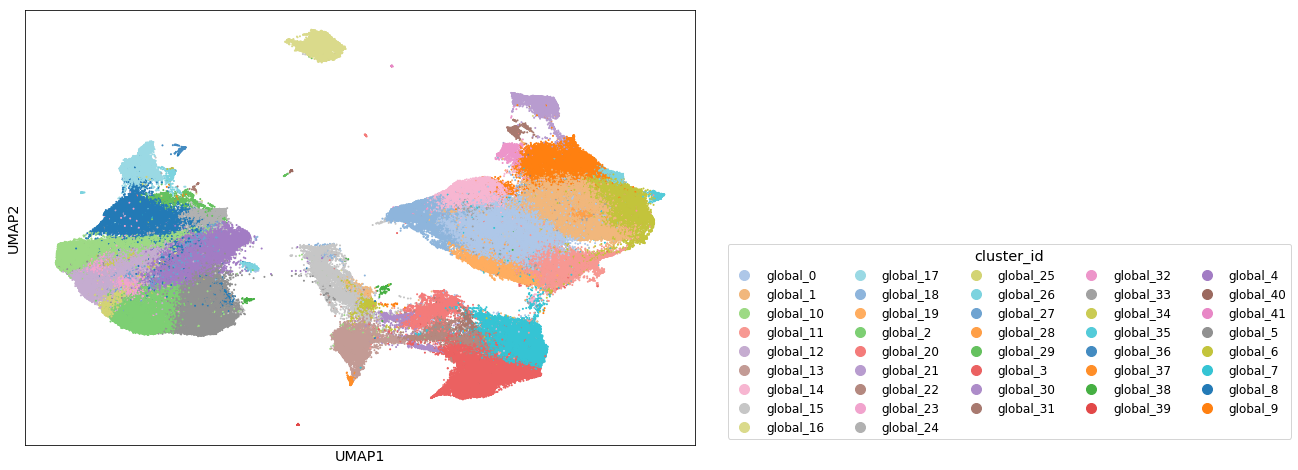

In [9]:
gexplorer.scatter_plot(primary_label='cluster_id', features=features, dim_reduction_method='UMAP',
                      discrete=True)

Above each data point is a single cell and they are coloured according to the the PhenoGraph clustering, performed on the entire concatenated dataset. Because there are so many clusters on one plot it can be difficult to discern clusters from one another. To get a better idea of the phenotype of each PhenoGraph cluster let's generate a heatmap of marker expression.

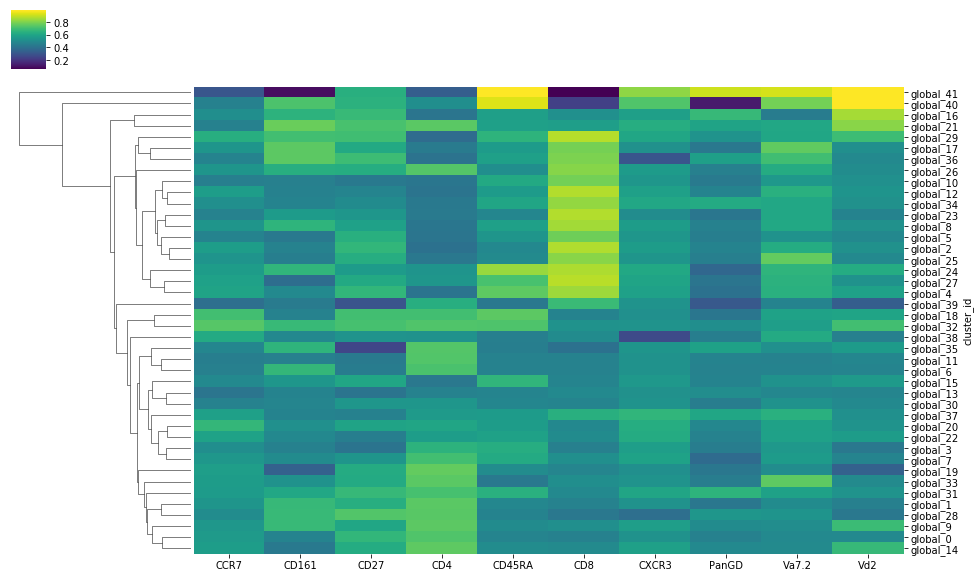

In [8]:
features = ['CCR7',
 'CD161',
 'CD27',
 'CD4',
 'CD45RA',
 'CD8',
 'CXCR3',
 'PanGD',
 'Va7.2',
 'Vd2']
gexplorer.heatmap(heatmap_var='cluster_id', features=features, clustermap=True)

The x-axis of the above heatmap gives each marker measured in this panel. On the y-axis is the cluster identified by PhenoGraph. The rows (clusters) are grouped using single-linkage clustering. The intensity of each cell is given by a colour (see key top left) and is the MFI after logicle transformation and scalled between 0 and 1.

Cluster 17 is the MAIT population. As shown, it successfully identified it as being distinct from CD8+ T cells (despite its similarity in marker expression) but despite PhenoGraphs sensitivity it does not reveal CD8- MAIT cells.

Clusters 'global_40' and 'global_41' stand out quite significantly with extreme values for Vd2 and CD45RA. They also are visibly outliers by looking at single linkage clustering. Because underneath Explorer it contains a plain Pandas DataFrame I can subset out these clusters like you would with any dataframe.

In [8]:
global_40 = gexplorer.data[gexplorer.data['cluster_id'] == 'global_40']
global_41 = gexplorer.data[gexplorer.data['cluster_id'] == 'global_41']

In [9]:
global_40.shape

(81, 30)

In [10]:
global_41.shape

(61, 30)

In [11]:
gexplorer.data.population_label.unique()

array(['XGBoost_CD4+CD8+', 'XGBoost_CD4+CD8-', 'XGBoost_CD4-CD8-',
       'XGBoost_CD4-CD8+', 'XGBoost_gdt', 'XGBoost_mait+CD4-CD8+',
       'XGBoost_mait+CD4+CD8+', 'XGBoost_mait+CD4+CD8-',
       'XGBoost_mait+CD4-CD8-'], dtype=object)

So both of these clusters are very small in size, with just 81 and 61 cells. To get a better understanding of what these populations are we can us the `plot_2d` method. This allows us to plot a cluster or gated population in 2d space and plot another population or cluster in contrast.

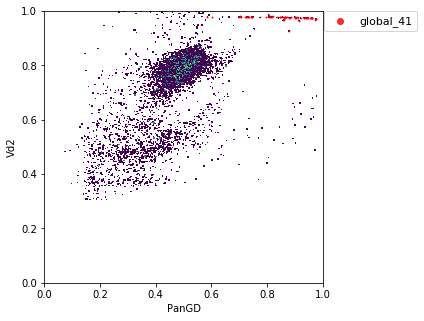

In [13]:
gexplorer.plot_2d(primary_id='XGBoost_gdt', contrasting_id='global_41', 
                          x='PanGD', y='Vd2', xlim=(0,1), ylim=(0,1))

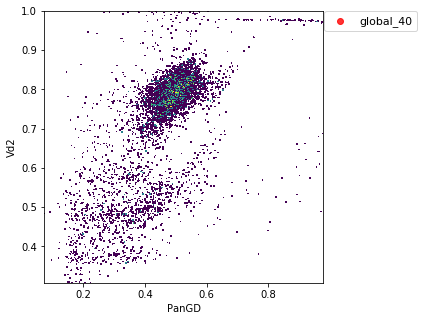

In [15]:
gexplorer.plot_2d(primary_id='XGBoost_gdt', contrasting_id='global_40', 
                          x='PanGD', y='Vd2')

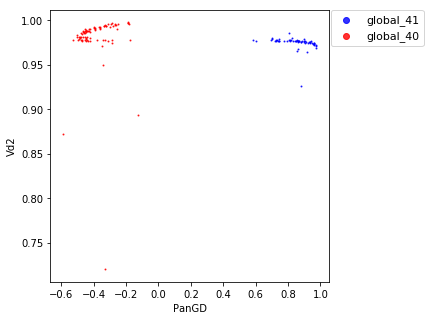

In [16]:
gexplorer.plot_2d(primary_id='global_41', contrasting_id='global_40', 
                          x='PanGD', y='Vd2')

These two clusters are clearly outliers and can be removed from further analysis by using the `drop_data` method. This method takes a standard pandas dataframe mask of boolean values indicting what to drop and what to keep.

In [12]:
gexplorer.drop_data(~gexplorer.data['cluster_id'].isin(['global_41', 'global_40']))

In [13]:
gexplorer.save('global_pdmc_t_CLEAN.csv')

Now repeat what we did above with the clusters removed.

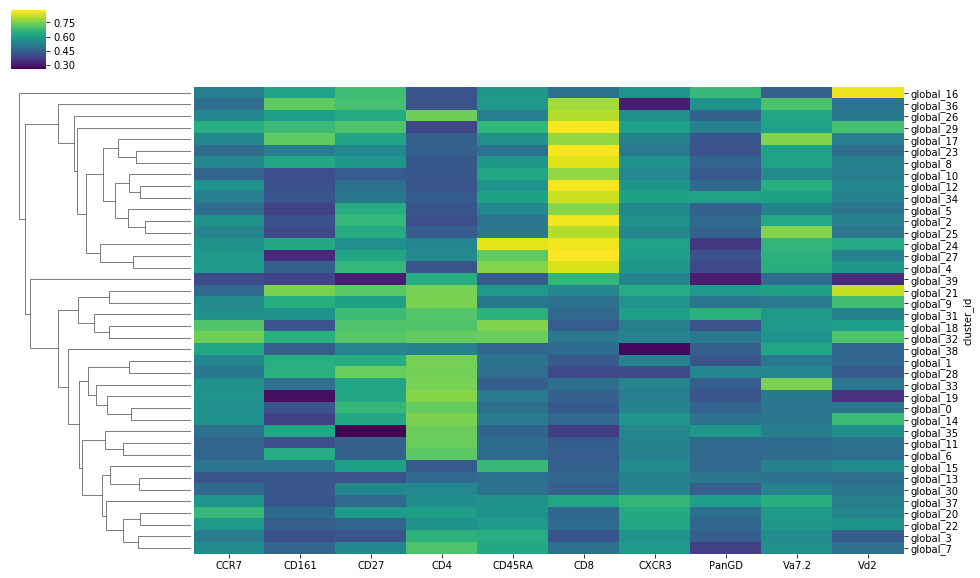

In [14]:
gexplorer.heatmap(heatmap_var='cluster_id', features=features, clustermap=True)

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


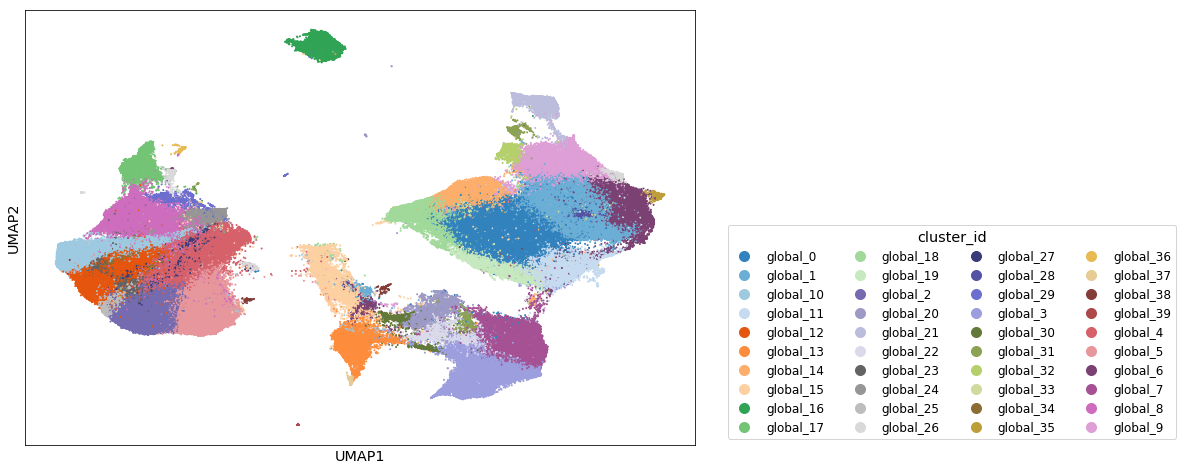

In [15]:
gexplorer.scatter_plot(primary_label='cluster_id', features=features, dim_reduction_method='UMAP',
                      discrete=True)

To get a perspective for the cell populations by classical definition, we can also colour datapoints according to how they were classified in relation to our traditional gating strategy.

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


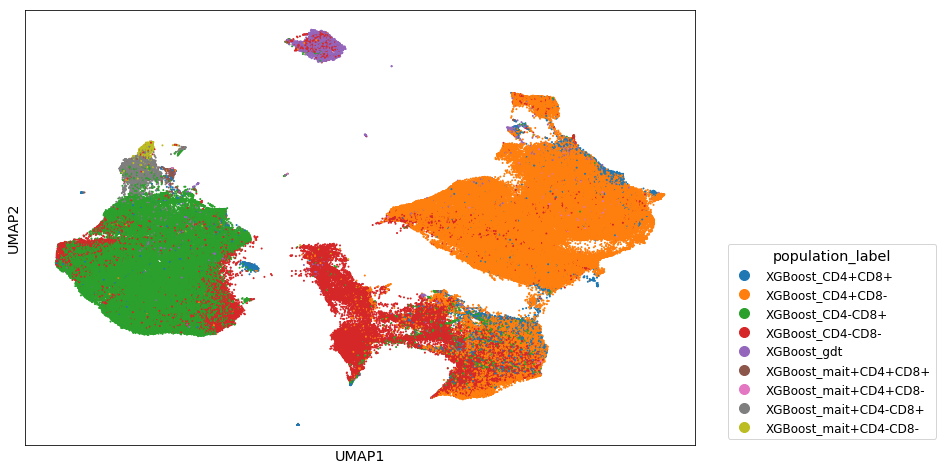

In [16]:
gexplorer.scatter_plot(primary_label='population_label', features=features, dim_reduction_method='UMAP',
                      discrete=True)

Gamma delta T cells nicely form a seperate cluster found at the top of the plot. Some cells which are CD4- and CD8- (therefore not captured by the gating strategy) fall within this island as well. Phenograph nicely classified all of these cells as belonging to the same cluster, so we can assume that there is little subdivision within this class.

The CD4+ and CD8+ T cells are nicely seperated in this display. Between them lies a middleground of CD4- CD8- subset, with some mixture with CD4+ T cells. The splatter of double positive (CD4+CD8+) form no consensus and therefore can be assumed to be noise. The MAIT cells are closer in relation to the CD8+ T cells, with a large population of CD8+ MAITs compared to CD4+. It should be noted however that PhenoGraph clusters these two subclasses together.

The CD4 and CD8 subsets are widely subsetted in the PhenoGraph clustering, suggesting smaller populations existing within this major classifications (something that makes sense given the wide heterogenity within these populations).

Note that the Explorer class saves the embeddings to new columns in the underlying dataframe. The columns are named after the method followed by a sequential integer denoting the component. This means in future plotting, if the same method and number of components are passed in as arguments, the computationally expensive task of dimensionality reduction does not have to be repeated. Be sure to save the dataframe regularly to avoid having to compute these variables repeatedly.

In [12]:
gexplorer.data[['UMAP_0', 'UMAP_1']].head(3)

,UMAP_0,UMAP_1
0,2.708725,-5.311717
1,1.608861,-5.076097
2,4.902682,-3.529548


In [13]:
gexplorer.save('global_pdmc_t_CLEAN.csv')

In [5]:
gexplorer = Explorer(path='global_pdmc_t_CLEAN.csv')

The PhenoGraph clustering is still hard to interpret on the UMAP plot simply due to the amount of clusters. We can pass a mask into the `scatter_plot` method to narrow our view.

Using the groups identified in the heatmap I can explore mask the scatter plot input to get a cleaner view. Cluster global_16 and global_39 are the outliers in our dendrogram; global 16 is the gamma delta t cells. I'll include these in all the plots for reference. Then for each plot lets subdivide by the common groups in the dendrogram.

In [28]:
cd8_mask = [f'global_{x}' for x in [4,27,24,25,2,5,34,12,10,8,23,17,29,26,36,39]]
cd4_mask1 = [f'global_{x}' for x in [39, 21,9,31,18, 32]]

In [29]:
features = ['CCR7', 'CD161', 'CD27',
            'CD4', 'CD45RA', 'CD8', 
            'CXCR3', 'FSC-A', 'FSC-H',
            'PanGD', 'SSC-A', 'SSC-W',
            'Va7.2', 'Vd2']

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


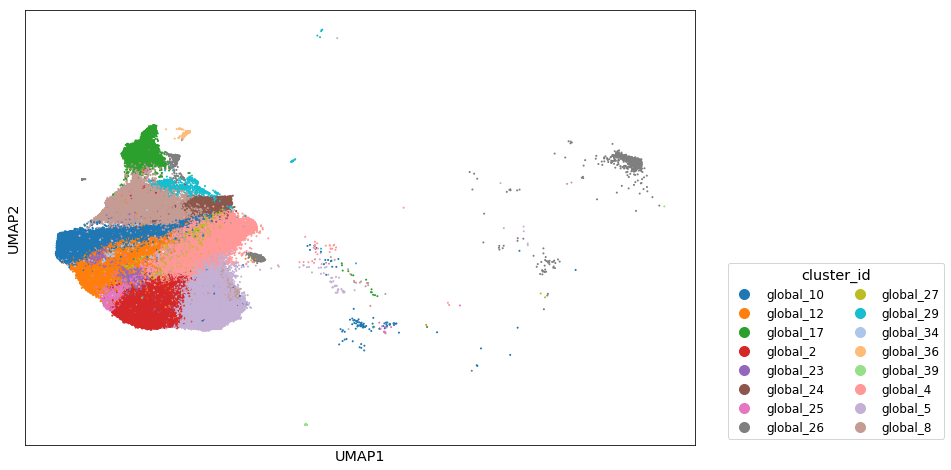

In [30]:
gexplorer.scatter_plot(primary_label='cluster_id', features=features, dim_reduction_method='UMAP',
                      mask=gexplorer.data.cluster_id.isin(cd8_mask), discrete=True)

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


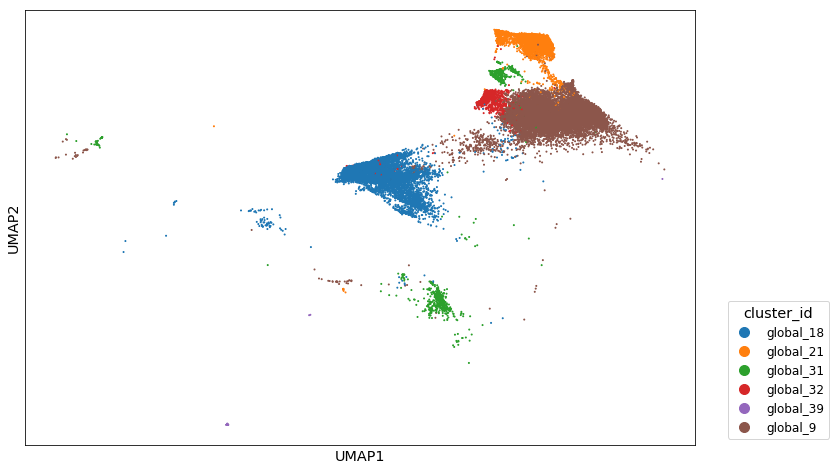

In [31]:
gexplorer.scatter_plot(primary_label='cluster_id', features=features, dim_reduction_method='UMAP',
                      mask=gexplorer.data.cluster_id.isin(cd4_mask1), discrete=True)

<h3>How accurate is global clustering in describing change in cell subsets</h3>

Despite clear seperation of populations we want to be certain that the global clustering is capturing true immunological similarities between the patients rather than clustering cells on their origin instead.

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


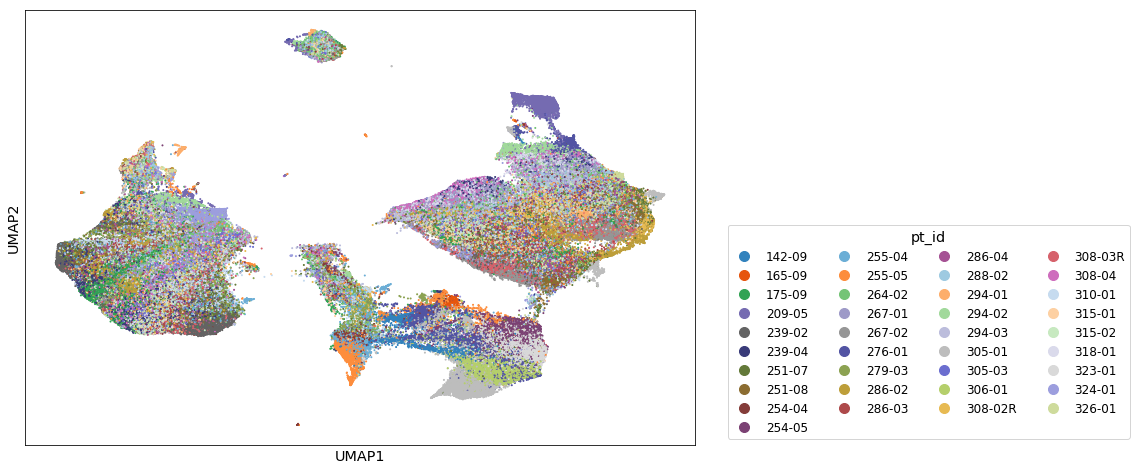

In [32]:
gexplorer.scatter_plot(primary_label='pt_id', features=features, dim_reduction_method='UMAP', discrete=True)

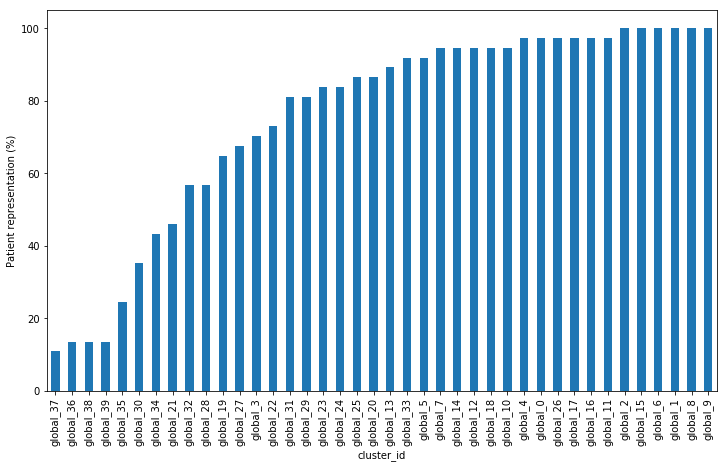

In [35]:
gexplorer.plot_representation(x_variable='cluster', y_variable='patient')

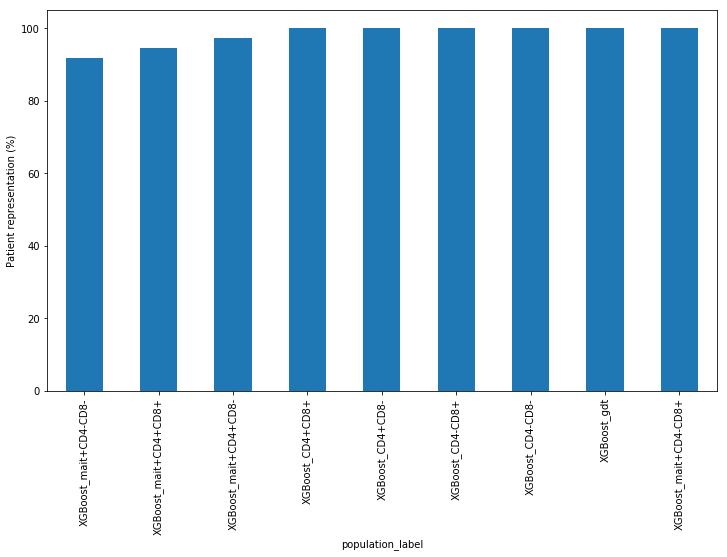

In [36]:
gexplorer.plot_representation(x_variable='population', y_variable='patient')

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


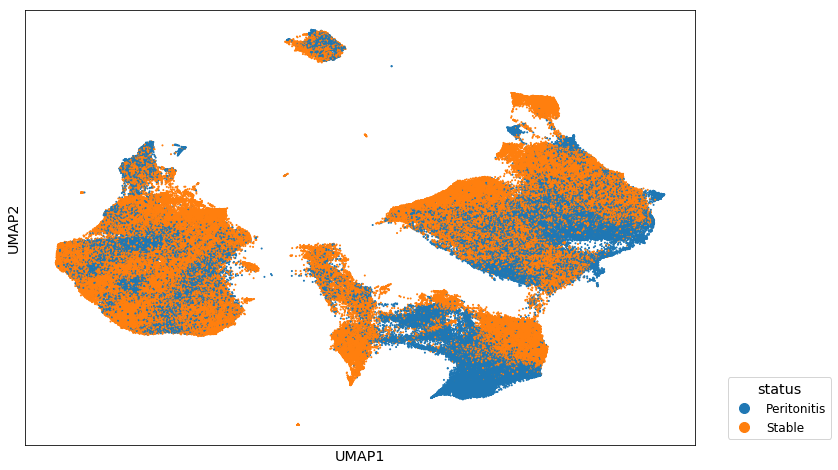

In [43]:
gexplorer.scatter_plot(primary_label='status', 
                       features=features, dim_reduction_method='UMAP', 
                       discrete=True)

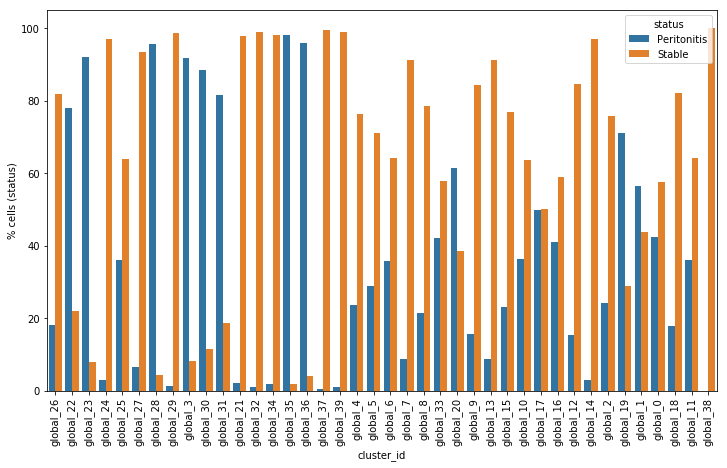

In [39]:
gexplorer.plot_representation(x_variable='cluster', y_variable='status')

Embeddings for UMAP already exist, change arg "overwrite" to True to overwrite existing


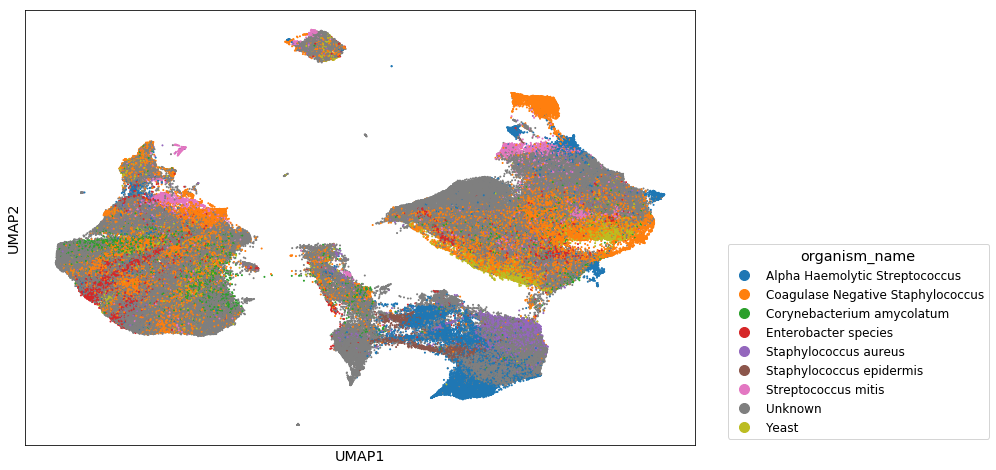

In [46]:
gexplorer.scatter_plot(primary_label='organism_name', 
                       features=features, dim_reduction_method='UMAP', 
                       discrete=True)

<h1>Single clustering followed by Meta-Clustering</h1>

Global clustering is okay for this sort of exploratory analysis, but as seen it can be unrealiable due to the heterogenity of our patients. For this reason it is better to analyse patients individually and then find some consensus between them. An example of clustering a single sample is given below.

In [6]:
# Load our PhenoGraph clustering definition
cdef = ClusteringDefinition.objects(clustering_uid='PhenoGraph').get()

In [7]:
# Initialise our clustering object
scluster = SingleClustering(clustering_definition=cdef)

In [8]:
# Load a sample, in this case we will just load the first sample
scluster.load_data(experiment=texp, sample_id=samples[0])

In [9]:
# Perform clustering using the cluster method
scluster.cluster()

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2056293487548828 seconds
Jaccard graph constructed in 0.29054713249206543 seconds
Wrote graph to binary file in 0.19566607475280762 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.734242
After 2 runs, maximum modularity is Q = 0.73567
After 3 runs, maximum modularity is Q = 0.738148
After 10 runs, maximum modularity is Q = 0.741134
Louvain completed 30 runs in 1.0887506008148193 seconds
PhenoGraph complete in 1.790297031402588 seconds


The main difference to what we have seen previously, is that when running clustering on a single sample, the data is saved to the underlying database using the `save_clusters` method. This allows us to accumulate clustering information on every sample so that we can then perform meta-clustering across an entire experiment.

In [10]:
scluster.save_clusters()

We can just loop over the remaining samples and execute the above code on each.

In [13]:
print('------ Cluster all samples -------')
for s in samples[1:]:
    print('\n')
    print(f'{s}.....')
    print('\n')
    scluster = SingleClustering(clustering_definition=cdef)
    scluster.load_data(experiment=texp, sample_id=s)
    scluster.cluster()
    scluster.save_clusters()
    print('----------------------------')
print('---------- Completed! -----------')

------ Cluster all samples -------


165-09_pdmc_t.....


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1045827865600586 seconds
Jaccard graph constructed in 0.17697572708129883 seconds
Wrote graph to binary file in 0.043111562728881836 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.667876
After 2 runs, maximum modularity is Q = 0.673828
After 3 runs, maximum modularity is Q = 0.676155
Louvain completed 23 runs in 0.6836357116699219 seconds
PhenoGraph complete in 1.015082597732544 seconds
----------------------------


175-09_pdmc_t.....


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.06158709526062 seconds
Jaccard graph constructed in 4.4287378787994385 seconds
Wrote graph to binary file in 3.139841079711914 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.844238
After 2 runs, maximum modularity is Q =

Louvain completed 43 runs in 47.2133514881134 seconds
PhenoGraph complete in 57.119757890701294 seconds
----------------------------


286-04_pdmc_t.....


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 121.79456210136414 seconds
Jaccard graph constructed in 24.00149154663086 seconds
Wrote graph to binary file in 15.39708161354065 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.851982
Louvain completed 21 runs in 359.5868990421295 seconds
PhenoGraph complete in 521.6632070541382 seconds
----------------------------


294-02_pdmc_t.....


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.20514512062072754 seconds
Jaccard graph constructed in 0.4621622562408447 seconds
Wrote graph to binary file in 0.14580106735229492 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.818307
After 16 runs, maximum modularity is Q =

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 7.974089622497559 seconds
Jaccard graph constructed in 4.401040315628052 seconds
Wrote graph to binary file in 2.2915713787078857 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.86315
After 3 runs, maximum modularity is Q = 0.864988
After 4 runs, maximum modularity is Q = 0.866266
Louvain completed 24 runs in 56.769203662872314 seconds
PhenoGraph complete in 71.54289484024048 seconds
----------------------------


267-01_pdmc_t.....


Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.329907178878784 seconds
Jaccard graph constructed in 1.9035611152648926 seconds
Wrote graph to binary file in 1.2648022174835205 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.826124
After 2 runs, maximum modularity is Q = 0.829509
After 3 runs, maximum modularity is Q = 0.830549
Lou

In [7]:
meta = MetaClustering(clustering_definition=cdef, experiment=texp, samples=samples)

--------- Meta Clustering: Loading data ---------
Each sample will be fetched from the database and a summary matrix created. Each row of this summary matrix will be a vector describing the centroid (the median of each channel/marker) of each cluster. 



------------ Completed! ------------


In [9]:
meta.cluster()

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.10356521606445312 seconds
Jaccard graph constructed in 0.29843902587890625 seconds
Wrote graph to binary file in 0.12213659286499023 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.806396
Louvain completed 21 runs in 0.6503195762634277 seconds
PhenoGraph complete in 1.1794946193695068 seconds


In [10]:
mexplorer = meta.explorer()

In [12]:
mexplorer.load_infectious_data()

In [13]:
mexplorer.load_meta('status')

In [16]:
mexplorer.data.groupby('meta_cluster_id')['cluster_size'].sum()

meta_cluster_id
cluster_0     793770.0
cluster_1     539212.0
cluster_10    113339.0
cluster_11      9295.0
cluster_2     884167.0
cluster_3     599756.0
cluster_4     271112.0
cluster_5      84184.0
cluster_6     511619.0
cluster_7      70934.0
cluster_8      93509.0
cluster_9     132634.0
Name: cluster_size, dtype: float64

In [18]:
from immunova.flow.dim_reduction import dimensionality_reduction
import matplotlib.pyplot as plt
import scprep

In [20]:
features = ['CCR7', 'CD161', 'CD27',
            'CD4', 'CD45RA', 'CD8', 
            'CXCR3', 'FSC-A', 'FSC-H',
            'PanGD', 'SSC-A', 'SSC-W',
            'Va7.2', 'Vd2']
d = dimensionality_reduction(data=mexplorer.data, features=features, n_components=2, method='UMAP')

In [30]:
size = d.cluster_size.values
size = (size - size.min())/(size.max() - size.min()) * 500

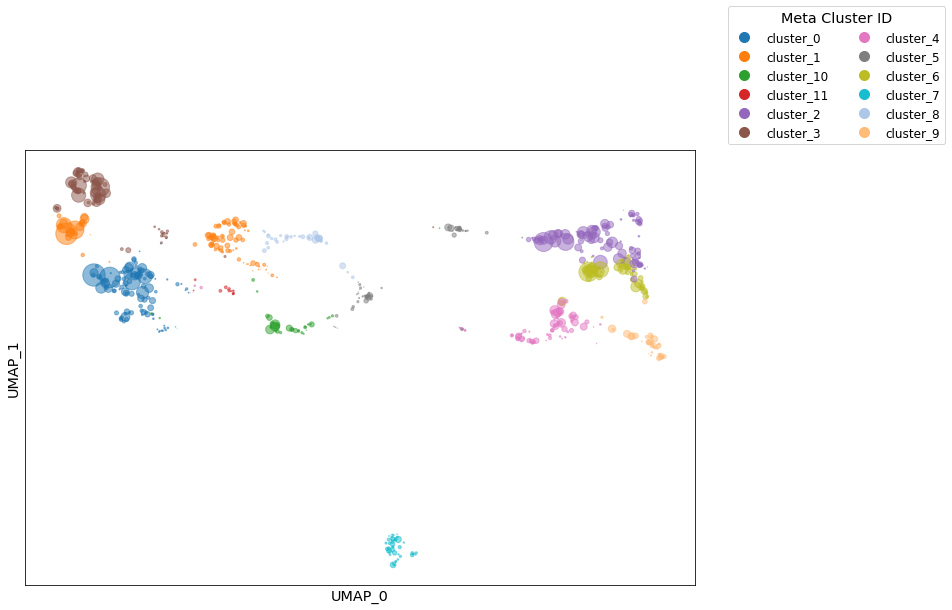

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))
scprep.plot.scatter2d(d[['UMAP_0', 'UMAP_1']], c=d.meta_cluster_id, ticks=False,
                           s=size, discrete=True, legend_loc="lower left",
                           legend_anchor=(1.04, 1), legend_title='Meta Cluster ID', ax=ax, alpha=0.5)

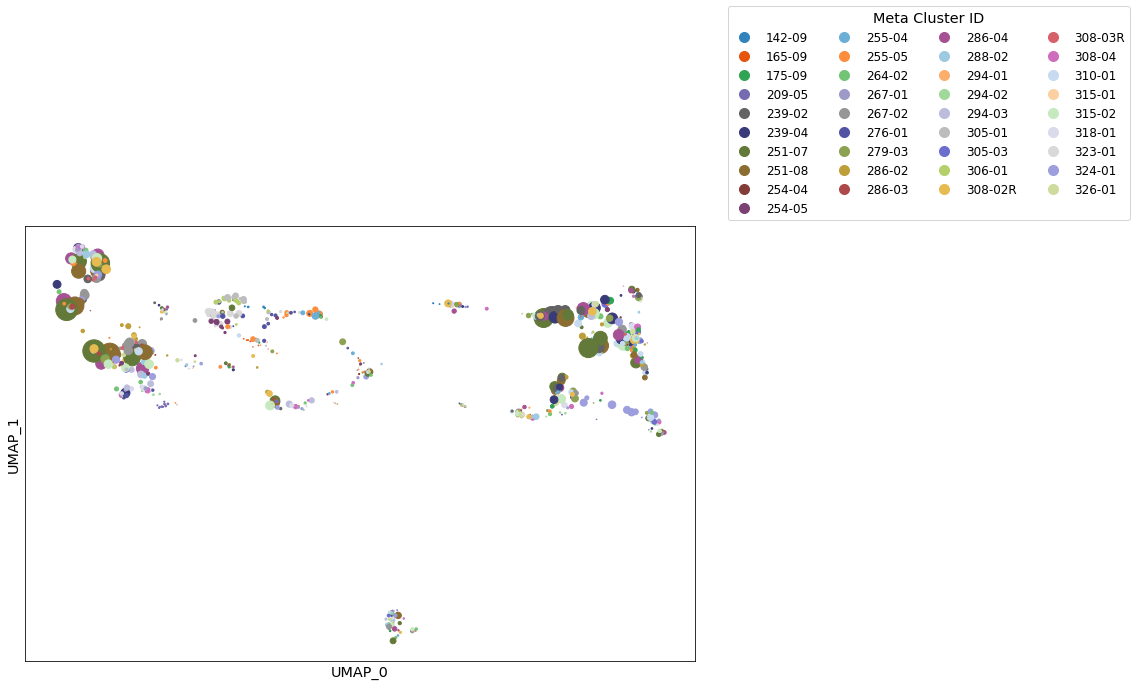

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
scprep.plot.scatter2d(d[['UMAP_0', 'UMAP_1']], c=d.pt_id, ticks=False,
                           s=size, discrete=True, legend_loc="lower left",
                           legend_anchor=(1.04, 1), legend_title='Meta Cluster ID', ax=ax)

In [34]:
%matplotlib widget
d = dimensionality_reduction(data=mexplorer.data, features=features, n_components=3, method='UMAP')
size = d.cluster_size.values
size = (size - size.min())/(size.max() - size.min()) * 500
scprep.plot.scatter3d(d[['UMAP_0', 'UMAP_1', 'UMAP_2']], c=d.meta_cluster_id, ticks=False,
                           s=size, discrete=True, legend_loc="lower left",
                           legend_anchor=(1.04, 1), legend_title='Meta Cluster ID', figsize=(12,8),
                     alpha=0.5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Calculating PHATE...
  Running PHATE on 763 cells and 10 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.10 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.12 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.03 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.34 seconds.
Calculated PHATE in 0.62 seconds.


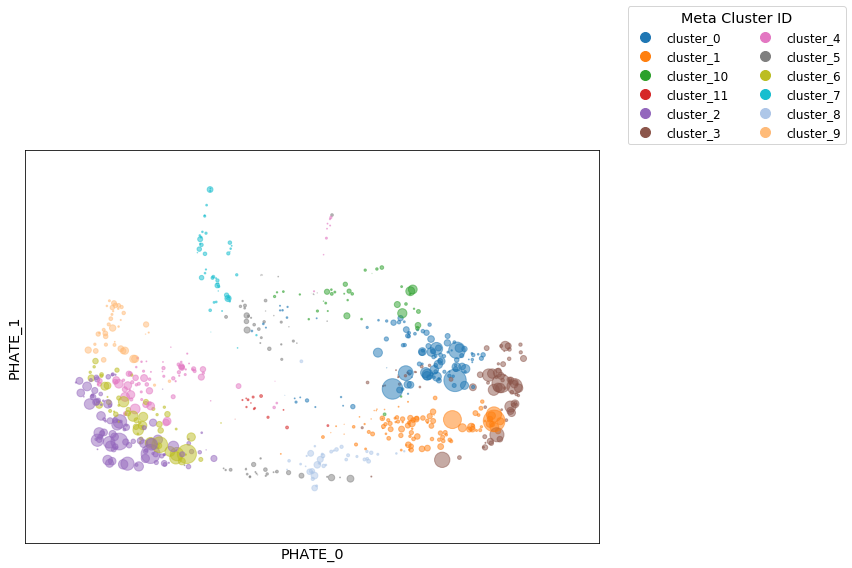

In [46]:
%matplotlib inline
d = dimensionality_reduction(data=mexplorer.data, features=features, n_components=2, method='PHATE')
size = d.cluster_size.values
size = (size - size.min())/(size.max() - size.min()) * 500
scprep.plot.scatter2d(d[['PHATE_0', 'PHATE_1']], c=d.meta_cluster_id, ticks=False,
                           s=size, discrete=True, legend_loc="lower left",
                           legend_anchor=(1.04, 1), legend_title='Meta Cluster ID', figsize=(12,8),
                     alpha=0.5)

Calculating PHATE...
  Running PHATE on 763 cells and 10 genes.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 0.13 seconds.
  Calculating optimal t...
  Calculated optimal t in 0.13 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.04 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.34 seconds.
Calculated PHATE in 0.64 seconds.


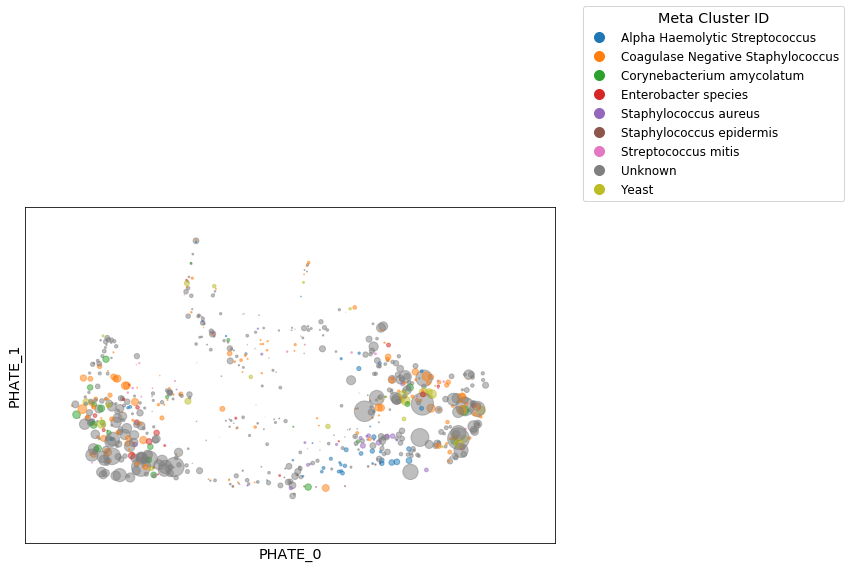

In [49]:
%matplotlib inline
d = dimensionality_reduction(data=mexplorer.data, features=features, n_components=2, method='PHATE')
size = d.cluster_size.values
size = (size - size.min())/(size.max() - size.min()) * 500
scprep.plot.scatter2d(d[['PHATE_0', 'PHATE_1']], c=d.organism_name, ticks=False,
                           s=size, discrete=True, legend_loc="lower left",
                           legend_anchor=(1.04, 1), legend_title='Meta Cluster ID', figsize=(12,8),
                     alpha=0.5)

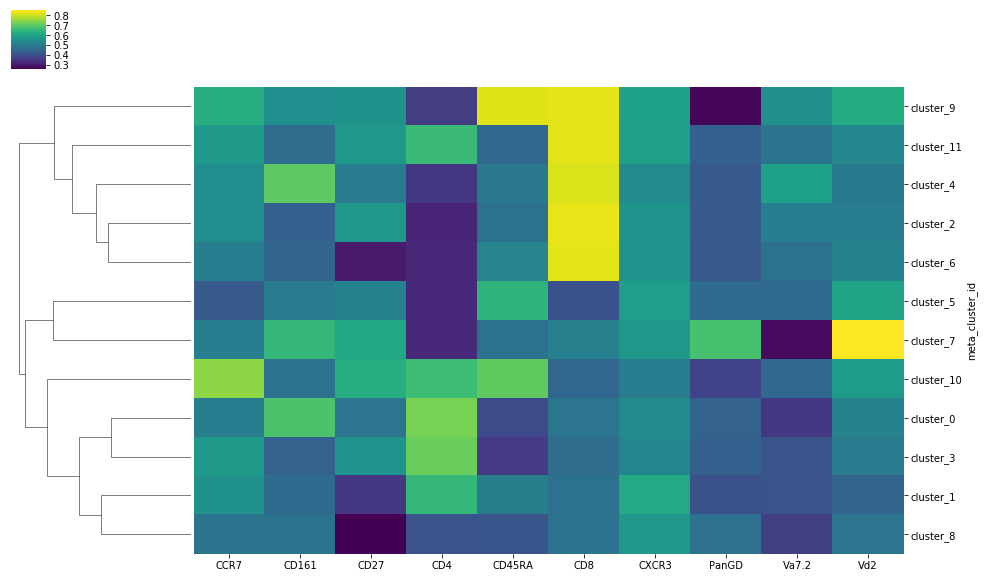

In [38]:
%matplotlib inline
features = ['CCR7',
 'CD161',
 'CD27',
 'CD4',
 'CD45RA',
 'CD8',
 'CXCR3',
 'PanGD',
 'Va7.2',
 'Vd2']
mexplorer.heatmap('meta_cluster_id', features=features, clustermap=True)

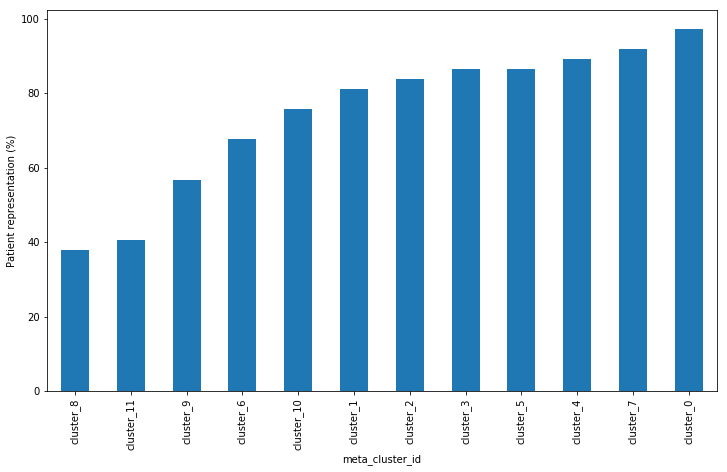

In [42]:
mexplorer.plot_representation(x_variable='meta cluster', y_variable='patient')

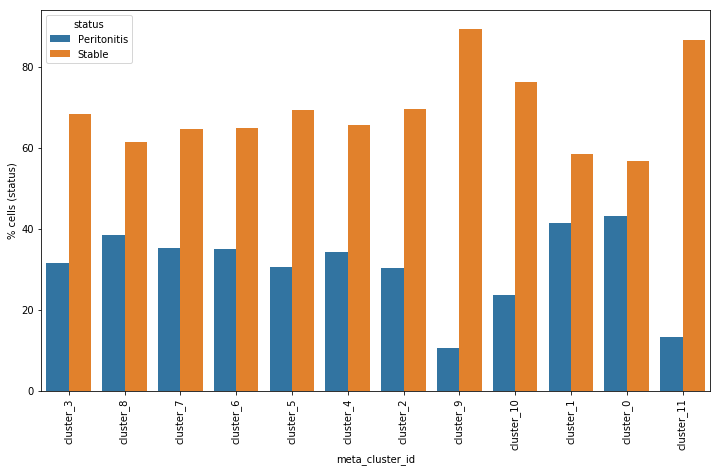

In [43]:
mexplorer.plot_representation(x_variable='meta cluster', y_variable='status')

In [45]:
mexplorer.data.columns

Index(['CCR7', 'CD161', 'CD27', 'CD4', 'CD45RA', 'CD8', 'CXCR3', 'FSC-A',
       'FSC-H', 'PanGD', 'SSC-A', 'SSC-W', 'Va7.2', 'Vd2', 'sample_id',
       'cluster_id', 'CD3', 'L/D', 'Time', 'cluster_size', 'pt_id', 'SSC-H',
       'FSC-W', 'meta_cluster_id', 'organism_name', 'organism_type', 'hmbpp',
       'ribo', 'status'],
      dtype='object')